# Provided Code

In [135]:
!apt-get install -qq libproj-dev proj-data proj-bin
!apt-get install -qq libgeos-dev
!pip install shapely --no-binary shapely
!pip install cartopy
!pip install python-louvain

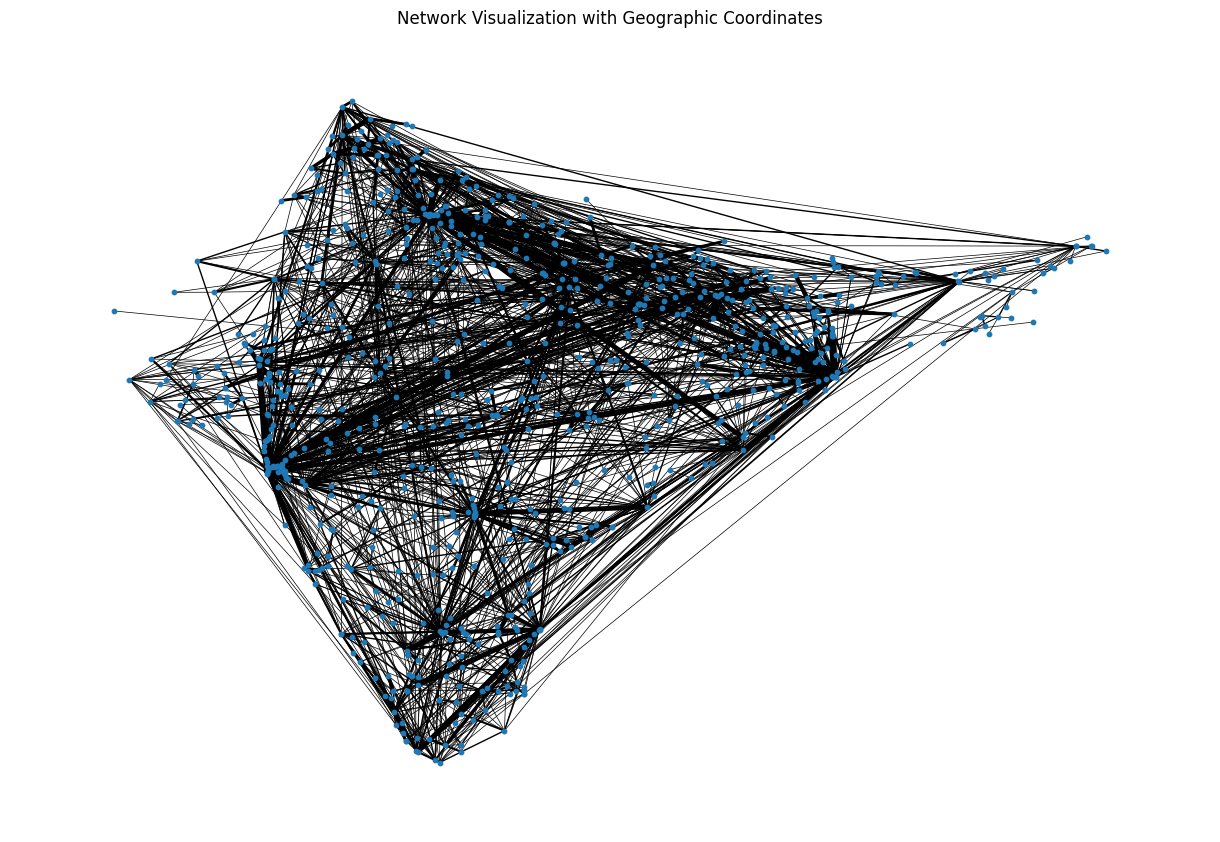

In [136]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

nodes_df = pd.read_csv('https://raw.githubusercontent.com/Dashlander/public_files/main/datawithlatlong.csv')
edges_df = pd.read_csv('https://raw.githubusercontent.com/Dashlander/public_files/main/edgesweighted.csv')

# Create a new graph object
G = nx.Graph()

# Add nodes to the graph with their position set by their latitude and longitude
for index, row in nodes_df.iterrows():
    G.add_node(row['Id'], pos=(row['LON'], row['LAT']), label=row['Stations'])

# Add edges to the graph
for index, row in edges_df.iterrows():
    G.add_edge(row['Source'], row['Target'], weight=row['Weight'])

# Get positions
pos = nx.get_node_attributes(G, 'pos')

# Draw the network
plt.figure(figsize=(12, 8))
nx.draw(G, pos, node_size=10, width=[(G[u][v]['weight']/2) for u,v in G.edges()], with_labels=False)
plt.title('Network Visualization with Geographic Coordinates')
plt.show()


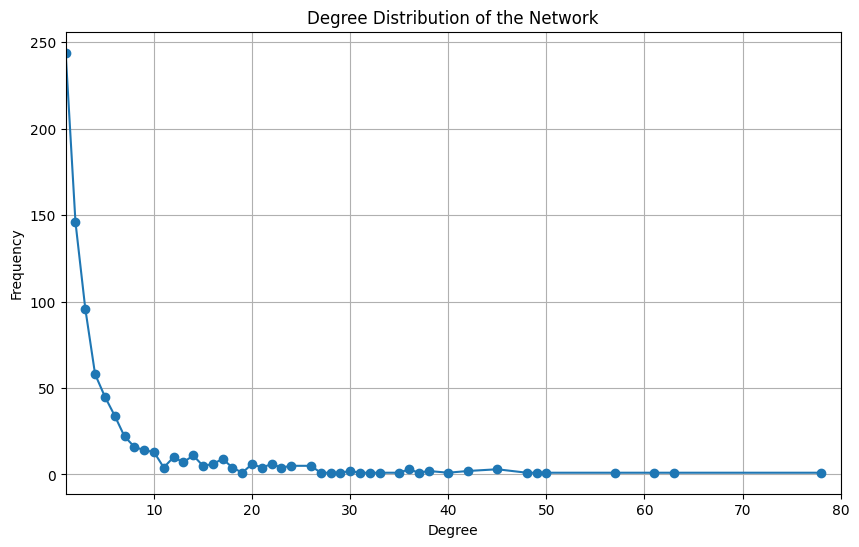

In [137]:
import numpy as np

# Calculate the degrees of all nodes
degrees = [degree for node, degree in nx.degree(G)]

# Calculate the frequency of each degree value
degree_values = np.unique(degrees)
degree_counts = [degrees.count(x) for x in degree_values]

# Plot the degree distribution
plt.figure(figsize=(10, 6))
plt.plot(degree_values, degree_counts, 'o-') # 'o-' creates a line plot with circle markers
plt.xlabel('Degree')
plt.xlim([1,80])
plt.ylabel('Frequency')
plt.title('Degree Distribution of the Network')
plt.grid(True)
plt.show()


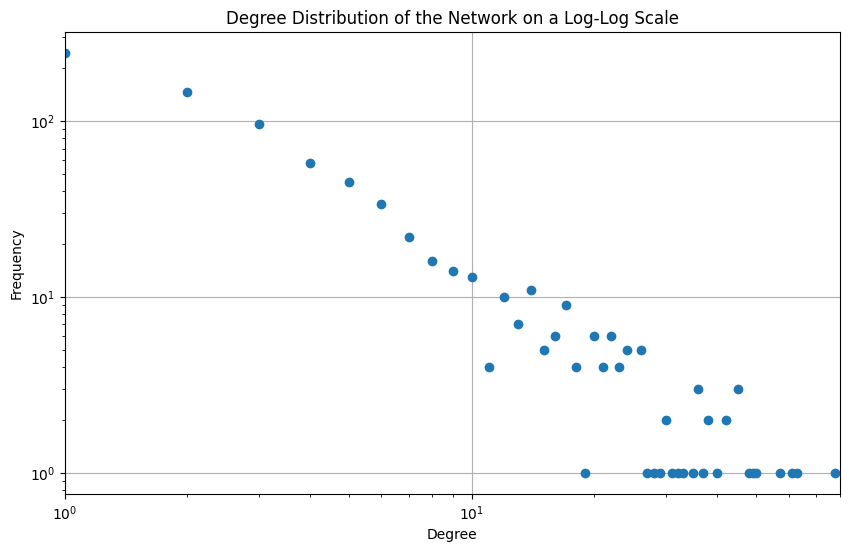

In [138]:
# Plot the degree distribution on a log-log scale
plt.figure(figsize=(10, 6))
plt.loglog(degree_values, degree_counts, 'o') # 'o-' creates a line plot with circle markers on a log-log scale
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution of the Network on a Log-Log Scale')
plt.grid(True)
plt.xlim([1, 80]) # Set the limit for the x-axis
plt.show()


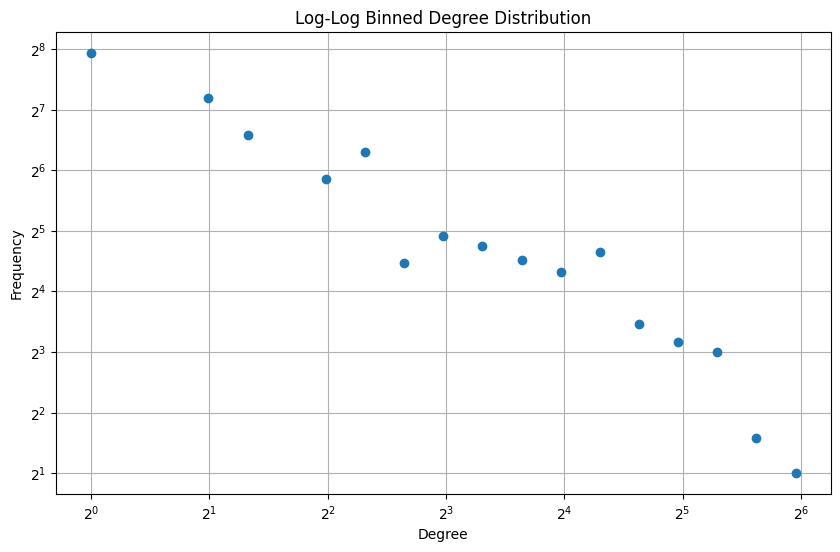

In [139]:
import numpy as np
import matplotlib.pyplot as plt
import collections  # Import the collections module

# Function to perform log binning
def log_binning(counter_dict, bin_count=10):
    max_exponent = np.log2(max(counter_dict.keys()))
    max_value = 2**max_exponent
    bins = np.logspace(0, max_exponent, num=bin_count, base=2)
    binned_counts = np.histogram(list(counter_dict.keys()), bins=bins, weights=list(counter_dict.values()))[0]
    binned_degrees = np.histogram(list(counter_dict.keys()), bins=bins)[1]
    return binned_degrees[:-1], binned_counts

# Calculate the degree of each node
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degree_count = collections.Counter(degree_sequence)
deg, cnt = zip(*degree_count.items())

# Perform log binning
binned_deg, binned_cnt = log_binning(degree_count, bin_count=20)

# Plot the degree distribution after log binning on a log-log scale
plt.figure(figsize=(10, 6))
plt.loglog(binned_deg, binned_cnt, 'o', base=2)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Log-Log Binned Degree Distribution')
plt.grid(True)
plt.show()


Estimated power-law exponent (alpha): 2.1780097001863705
Standard error of the exponent estimate (sigma): 0.057966067842710536


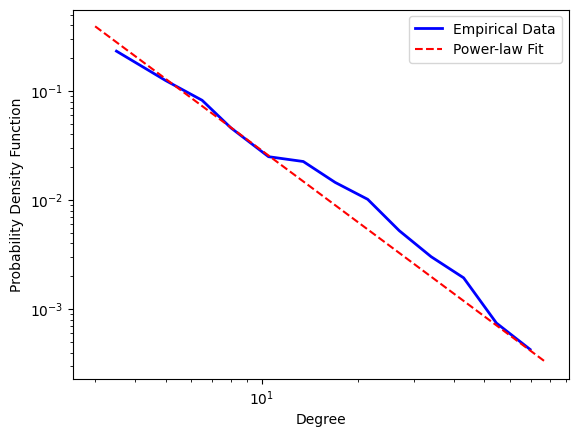

Loglikelihood ratio (R) comparing power law and exponential distributions: 4.746447543342176
p-value of the likelihood ratio test: 2.070203817894875e-06
The power-law distribution is a significantly better fit than the exponential distribution.


In [140]:
!pip install powerlaw
import powerlaw
import networkx as nx
import matplotlib.pyplot as plt

# Assuming G is your networkx graph
degrees = [degree for node, degree in G.degree() if degree > 0]  # Exclude nodes with degree 0

# Fit the degree distribution to a power-law distribution
fit = powerlaw.Fit(degrees, xmin=3)
alpha = fit.power_law.alpha
sigma = fit.power_law.sigma

print(f"Estimated power-law exponent (alpha): {alpha}")
print(f"Standard error of the exponent estimate (sigma): {sigma}")

# Plot the degree distribution and the power-law fit
fig = fit.plot_pdf(color='b', linewidth=2, label='Empirical Data')
fit.power_law.plot_pdf(color='r', linestyle='--', label='Power-law Fit')
plt.xlabel('Degree')
plt.ylabel('Probability Density Function')
plt.legend(loc='upper right')
plt.show()

# Calculate the goodness of fit
R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print(f"Loglikelihood ratio (R) comparing power law and exponential distributions: {R}")
print(f"p-value of the likelihood ratio test: {p}")

# Interpretation of results
if p < 0.05:
    print("The power-law distribution is a significantly better fit than the exponential distribution.")
else:
    print("There is not enough evidence to conclude that the power-law distribution is a better fit than the exponential distribution.")


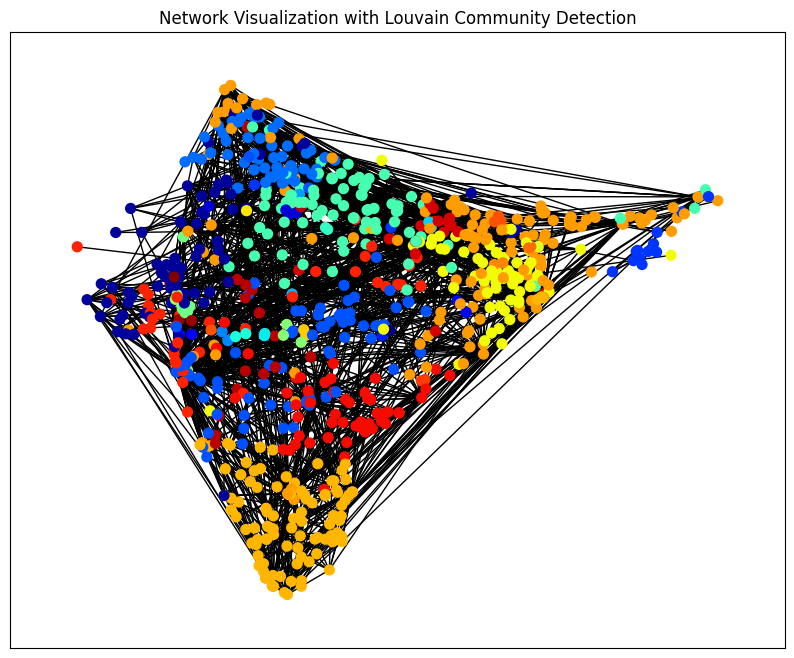

In [141]:
import matplotlib.pyplot as plt
import networkx as nx

# Assuming G is your networkx graph
# Detect communities
communities = nx.community.louvain_communities(G, seed=123)

# Create a mapping from node to community index
community_map = {}
for idx, community in enumerate(communities):
    for node in community:
        community_map[node] = idx

# Color mapping
colors = [community_map[node] for node in G.nodes()]

# Plotting
plt.figure(figsize=(10, 8))
nx.draw_networkx(G, pos=pos, node_color=colors, cmap=plt.cm.jet, node_size=50, with_labels=False)
plt.title('Network Visualization with Louvain Community Detection')
plt.show()


In [142]:
r = nx.degree_pearson_correlation_coefficient(G)
print(f"{r:3.15f}")


0.043684890051637


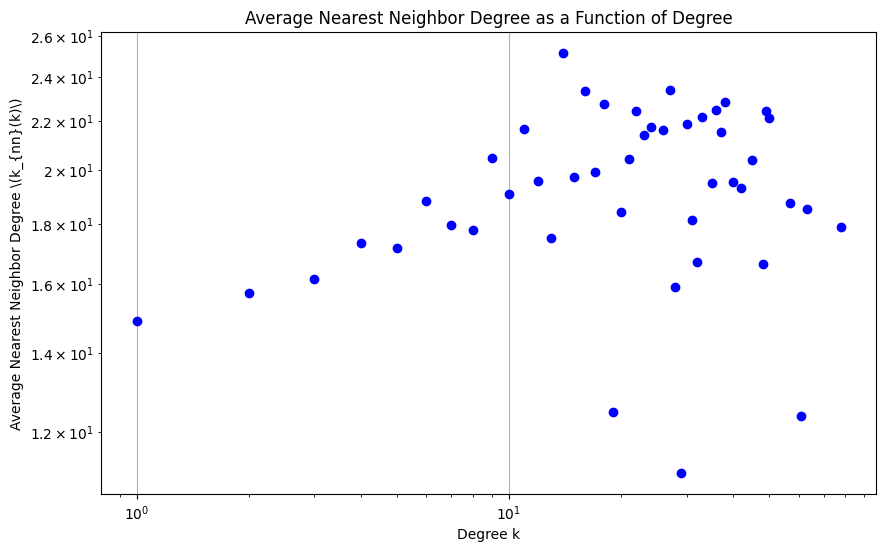

In [143]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Assuming G is your networkx graph

# Calculate the degree of each node
degrees = dict(G.degree())
k_values = np.array(list(degrees.values()))
unique_k = np.unique(k_values)

# Calculate k_nn for each node
k_nn = {node: np.mean([degrees[n] for n in G.neighbors(node)]) if len(list(G.neighbors(node))) > 0 else 0 for node in G.nodes()}

# Aggregate k_nn by k
k_nn_k = [np.mean([k_nn[node] for node in G.nodes() if degrees[node] == k]) for k in unique_k]

# Plot k_nn(k) versus k on a log-log scale
plt.figure(figsize=(10, 6))
plt.loglog(unique_k, k_nn_k, 'bo')
plt.xlabel('Degree k')
plt.ylabel('Average Nearest Neighbor Degree \(k_{nn}(k)\)')
plt.title('Average Nearest Neighbor Degree as a Function of Degree')
plt.grid(True)
plt.show()


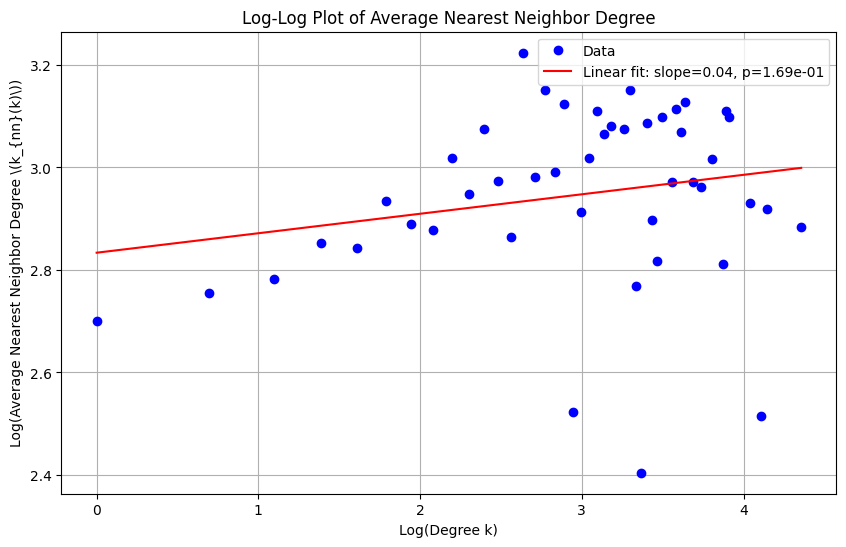

Slope of the linear regression line: 0.04
P-value for testing the null hypothesis that the slope is zero: 1.69e-01


In [144]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Ensure k_nn_k is a NumPy array
unique_k = np.array(unique_k)
k_nn_k = np.array(k_nn_k)

# Filter out zero values to avoid log(0)
non_zero_indices = (unique_k > 0) & (k_nn_k > 0)
log_k = np.log(unique_k[non_zero_indices])
log_k_nn_k = np.log(k_nn_k[non_zero_indices])

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(log_k, log_k_nn_k)

# Plot the original data and the linear regression line
plt.figure(figsize=(10, 6))
plt.plot(log_k, log_k_nn_k, 'bo', label='Data')
plt.plot(log_k, intercept + slope*log_k, 'r-', label=f'Linear fit: slope={slope:.2f}, p={p_value:.2e}')
plt.xlabel('Log(Degree k)')
plt.ylabel('Log(Average Nearest Neighbor Degree \(k_{nn}(k)\))')
plt.title('Log-Log Plot of Average Nearest Neighbor Degree')
plt.legend()
plt.grid(True)
plt.show()

# Print the slope and its significance
print(f"Slope of the linear regression line: {slope:.2f}")
print(f"P-value for testing the null hypothesis that the slope is zero: {p_value:.2e}")


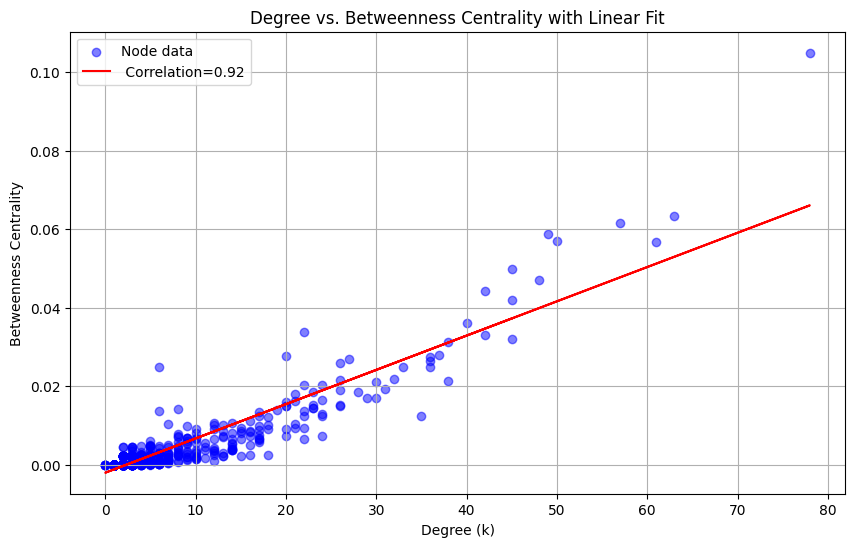

Slope: 0.00
Pearson correlation coefficient: 0.92
P-value: 0.00e+00


In [145]:
import matplotlib.pyplot as plt
import networkx as nx
from scipy import stats
import numpy as np

# Calculate node degree and betweenness centrality
node_degrees = np.array([degree for node, degree in G.degree()])
betweenness_values = np.array([value for node, value in nx.betweenness_centrality(G).items()])

# Calculate the Pearson correlation coefficient
correlation_coefficient, _ = stats.pearsonr(node_degrees, betweenness_values)

# Perform linear regression to get the line of best fit
slope, intercept, _, p_value, _ = stats.linregress(node_degrees, betweenness_values)

# Generate regression line values
line_values = slope * node_degrees + intercept

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(node_degrees, betweenness_values, color='blue', alpha=0.5, label='Node data')
plt.plot(node_degrees, line_values, 'r-', label=f' Correlation={correlation_coefficient:.2f}')
plt.xlabel('Degree (k)')
plt.ylabel('Betweenness Centrality')
plt.title('Degree vs. Betweenness Centrality with Linear Fit')
plt.legend()
plt.grid(True)
plt.show()

# Print the slope, correlation coefficient, and p-value
print(f"Slope: {slope:.2f}")
print(f"Pearson correlation coefficient: {correlation_coefficient:.2f}")
print(f"P-value: {p_value:.2e}")


In [146]:
node_degrees

array([ 1,  2,  1,  1,  1,  4, 13,  1,  1,  3, 13,  8, 49,  9,  1, 36,  3,
        5,  5,  9,  2, 21,  7,  3,  2, 17,  2,  5,  1,  3, 10, 36,  8,  1,
       24,  3,  1,  1,  3,  3,  9,  3,  1,  1, 26,  2,  2,  3,  2,  4,  7,
        1,  2,  1,  2,  1,  3,  1,  1,  2,  2,  4,  5,  1,  3,  1,  7,  3,
        3,  2,  2,  3, 35,  6, 42,  5,  2,  3,  1,  2,  2,  2, 12,  4,  6,
       20,  2,  2,  4,  3,  2,  1,  4,  7,  7,  1,  1,  1,  5,  4,  3,  1,
        2,  3,  1,  2,  1,  4,  5,  1,  2, 14, 11,  2,  3, 11,  5,  1, 10,
        1,  1,  1,  1,  1,  6,  2,  3,  6,  5, 16, 24,  6, 10,  2,  1,  6,
       22,  1, 26,  1,  8,  1,  1,  1,  1,  2,  1,  4,  2,  2,  2,  1,  1,
        4,  1,  2,  1,  3,  3, 15,  1,  5,  1,  2,  3,  1,  1, 18,  2,  2,
        1,  2,  3,  1,  5, 50, 29, 22,  1,  7,  1,  1,  3,  6,  2,  1,  1,
        1,  6,  1,  2,  3, 20,  1,  1,  2,  1,  5,  5,  1, 17,  3,  5,  1,
        2,  3, 16,  1,  2, 21,  1,  3,  2, 17,  4,  1, 61, 22,  2,  1,  1,
        1,  1,  0, 17,  1

In [147]:
betweenness_values

array([0.00000000e+00, 2.41914647e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.36767777e-04, 1.01110606e-02, 0.00000000e+00,
       0.00000000e+00, 2.27894537e-03, 2.91712803e-03, 2.98738964e-03,
       5.86841225e-02, 6.73779526e-03, 0.00000000e+00, 2.74616537e-02,
       2.98735414e-04, 2.20134699e-03, 5.95021297e-04, 9.85051187e-03,
       4.53604184e-05, 9.26123164e-03, 8.19499148e-04, 2.30041592e-03,
       0.00000000e+00, 6.68269678e-03, 2.83022044e-05, 5.95901843e-03,
       0.00000000e+00, 4.38734847e-04, 3.69927607e-03, 2.63407665e-02,
       7.36998150e-03, 0.00000000e+00, 7.19390254e-03, 2.31667618e-03,
       0.00000000e+00, 0.00000000e+00, 8.33305641e-05, 1.37971873e-04,
       6.70955461e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.14518376e-02, 1.68544789e-05, 2.46372128e-04, 1.72853564e-04,
       4.26170917e-04, 2.51846808e-03, 5.01879996e-03, 0.00000000e+00,
       2.83022044e-05, 0.00000000e+00, 1.91357563e-04, 0.00000000e+00,
      

# Continued examination


## Part wise Linear Regression

 First, we decided to do piece wise linear regression. This is done so that the examination is more complete.

 Simply speaking, taking the linear regression of an entire dataset does not take into account how the dataset behaves at one part of the dataset, and is reductive, as it averages out the entire dataset into a single value. Instead doing a part wise linear regression gives a better insight as we can look at regions and how different degree ranges affect the connectivity.

 As can be seen in the part wise linear regression, the lowest 25% degree nodes have a very positive linear correlation, but this changes drastically when we move to the highest 25%. This can be explained by the fact that networks do not exist in a vacuum, and are bound by real world limitations, such as resource constraints.

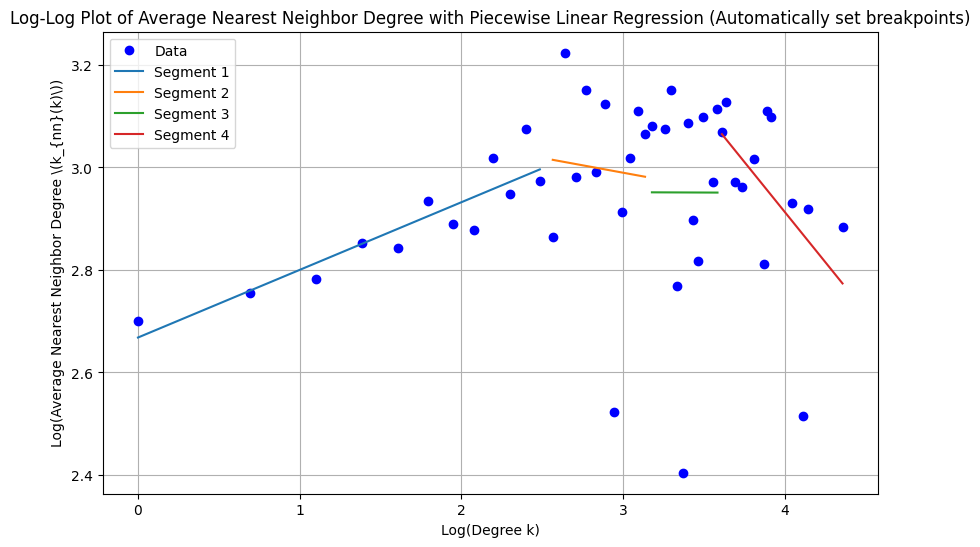

Slope of segment 1: 0.13
Slope of segment 2: -0.06
Slope of segment 3: -0.00
Slope of segment 4: -0.39


In [148]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Ensure k_nn_k is a NumPy array
unique_k = np.array(unique_k)
k_nn_k = np.array(k_nn_k)

# Filter out zero values to avoid log(0)
non_zero_indices = (unique_k > 0) & (k_nn_k > 0)
log_k = np.log(unique_k[non_zero_indices])
log_k_nn_k = np.log(k_nn_k[non_zero_indices])

# Automatically set breakpoints based on data distribution
percentiles = np.percentile(log_k, [25, 50, 75])  # You can adjust the percentiles as needed
breakpoints = [percentiles[0], percentiles[1], percentiles[2]]

# Perform piecewise linear regression
slopes = []
intercepts = []
for i in range(len(breakpoints) + 1):
    if i == 0:
        x_segment = log_k[log_k < breakpoints[i]]
        y_segment = log_k_nn_k[log_k < breakpoints[i]]
    elif i == len(breakpoints):
        x_segment = log_k[log_k >= breakpoints[i - 1]]
        y_segment = log_k_nn_k[log_k >= breakpoints[i - 1]]
    else:
        x_segment = log_k[(log_k >= breakpoints[i - 1]) & (log_k < breakpoints[i])]
        y_segment = log_k_nn_k[(log_k >= breakpoints[i - 1]) & (log_k < breakpoints[i])]

    slope, intercept, _, _, _ = stats.linregress(x_segment, y_segment)
    slopes.append(slope)
    intercepts.append(intercept)

# Plot the original data and the piecewise linear regression lines
plt.figure(figsize=(10, 6))
plt.plot(log_k, log_k_nn_k, 'bo', label='Data')

x_segments = []
y_segments = []
for i in range(len(breakpoints) + 1):
    if i == 0:
        x_segment = log_k[log_k < breakpoints[i]]
        y_segment = log_k_nn_k[log_k < breakpoints[i]]
    elif i == len(breakpoints):
        x_segment = log_k[log_k >= breakpoints[i - 1]]
        y_segment = log_k_nn_k[log_k >= breakpoints[i - 1]]
    else:
        x_segment = log_k[(log_k >= breakpoints[i - 1]) & (log_k < breakpoints[i])]
        y_segment = log_k_nn_k[(log_k >= breakpoints[i - 1]) & (log_k < breakpoints[i])]

    plt.plot(x_segment, intercepts[i] + slopes[i] * x_segment, label=f'Segment {i+1}')

plt.xlabel('Log(Degree k)')
plt.ylabel('Log(Average Nearest Neighbor Degree \(k_{nn}(k)\))')
plt.title('Log-Log Plot of Average Nearest Neighbor Degree with Piecewise Linear Regression (Automatically set breakpoints)')
plt.legend()
plt.grid(True)
plt.show()

# Print the slopes and their significance
for i, slope in enumerate(slopes):
    print(f"Slope of segment {i+1}: {slope:.2f}")


In order to find some interesting inferences, we divided the above data into different regions and performed linear fit on these small ranges, then using the data of slopes and intercepts from the above data, we trained a Linear Regression Model and predicted the value of slope for the further data and fund that the slope of came out to be negative, thus indicating a decrease in the value of Nearest Neighbour Degree with an increase in the degree of that node,this signifies that as a train station gets more connections (higher degree), its neighbors typically have fewer connections on average. In Indian railways, this suggests that busy stations may be surrounded by less busy ones, revealing a negative correlation between station connectivity and their neighbors' average connectivity.

Which might be necessary in long run because if we keep increasing the traffic on a particular station, then there will be a point where the station can't accept more traffic, but due to the presence of the property mentioned above it might be able to reduce its load/traffic by distributing the traffic with less busy stations, thus increasing the robustness of the network.

Slope of segment 1: 0.13
Slope of segment 2: 0.91
Slope of segment 3: -0.35
Slope of segment 4: -0.15
Slope of segment 5: -0.62
Slope of segment 6: 1.59
Slope of segment 7: -0.53
Slope of segment 8: -0.96
Predicted slope of next segment: -0.03241458047442176
Predicted intercept of next segment: 0.2383683988646113


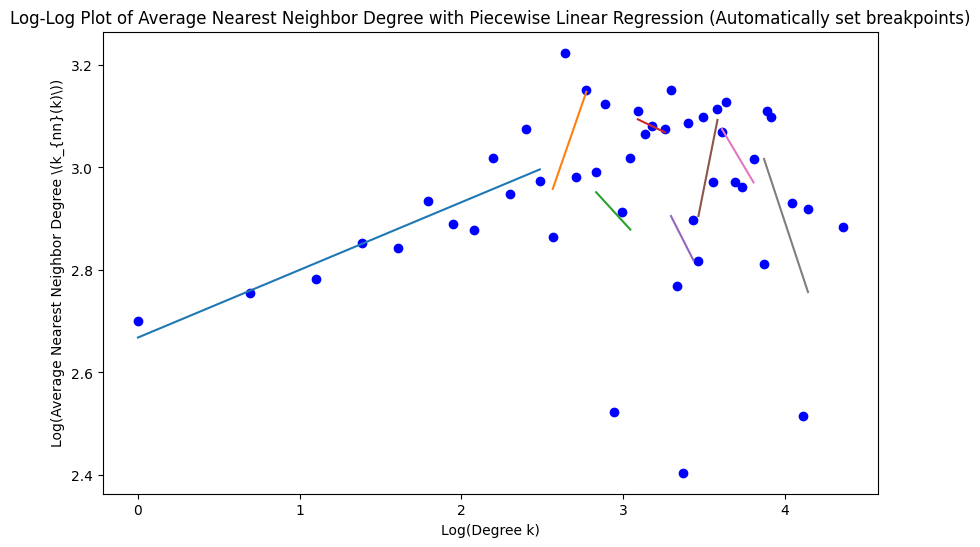

In [149]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Ensure k_nn_k is a NumPy array
unique_k = np.array(unique_k)
k_nn_k = np.array(k_nn_k)

# Filter out zero values to avoid log(0)
non_zero_indices = (unique_k > 0) & (k_nn_k > 0)
log_k = np.log(unique_k[non_zero_indices])
log_k_nn_k = np.log(k_nn_k[non_zero_indices])

# Automatically set breakpoints based on data distribution
percentiles = np.percentile(log_k, [0, 25, 35, 45, 55, 65, 75, 85, 100])  # You can adjust the percentiles as needed

# Perform piecewise linear regression
slopes = []
intercepts = []

# Plot the original data and the piecewise linear regression lines
plt.figure(figsize=(10, 6))
plt.plot(log_k, log_k_nn_k, 'bo', label='Data')

for i in range(len(percentiles) - 1):
    lower_percentile, upper_percentile = percentiles[i], percentiles[i + 1]

    x_segment = log_k[(log_k >= lower_percentile) & (log_k < upper_percentile)]
    y_segment = log_k_nn_k[(log_k >= lower_percentile) & (log_k < upper_percentile)]

    slope, intercept, _, _, _ = stats.linregress(x_segment, y_segment)
    slopes.append(slope)
    intercepts.append(intercept)

    plt.plot(x_segment, intercept + slope * x_segment, label=f'Segment {i + 1}: {lower_percentile}-{upper_percentile}')

plt.xlabel('Log(Degree k)')
plt.ylabel('Log(Average Nearest Neighbor Degree \(k_{nn}(k)\))')
plt.title('Log-Log Plot of Average Nearest Neighbor Degree with Piecewise Linear Regression (Automatically set breakpoints)')

# Print the slopes and their significance
for i, slope in enumerate(slopes):
    print(f"Slope of segment {i + 1}: {slope:.2f}")

# Train the linear regression model
X_train = np.arange(len(slopes))[:-1].reshape(-1, 1)
y_train = np.array(slopes[:-1]).reshape(-1, 1)

# Check if there are enough data points for training
if len(X_train) < 2 or len(y_train) < 2:
    print("Insufficient data points for training the linear regression model.")
else:
    # Ensure dimensions match before concatenating along axis 1
    if X_train.shape[0] == y_train.shape[0]:
        # Train the linear regression model
        model = stats.linregress(X_train.ravel(), y_train.ravel())

        # Predict the slope of the next segment
        predicted_slope = model.slope
        predicted_intercept = model.intercept

        # Print the predicted slope
        print("Predicted slope of next segment:", predicted_slope)
        print("Predicted intercept of next segment:", predicted_intercept)
    else:
        print("Mismatch in dimensions. Unable to train the linear regression model.")

## Communitty Algorithms

Using various community algorithms in addition to Louvain, such as Asynchronous Label Propagation Algorithm, as well as the Girvan-Newman Algorithm. From the resultant maps created, it would be fair to say that the Louvain's algorithms provides a much better insight as it has much more easily discernible commmunities, with comparable node numbers each community, unlike Asyn LPA or GNA, where the majority nodes belong to a particular community.

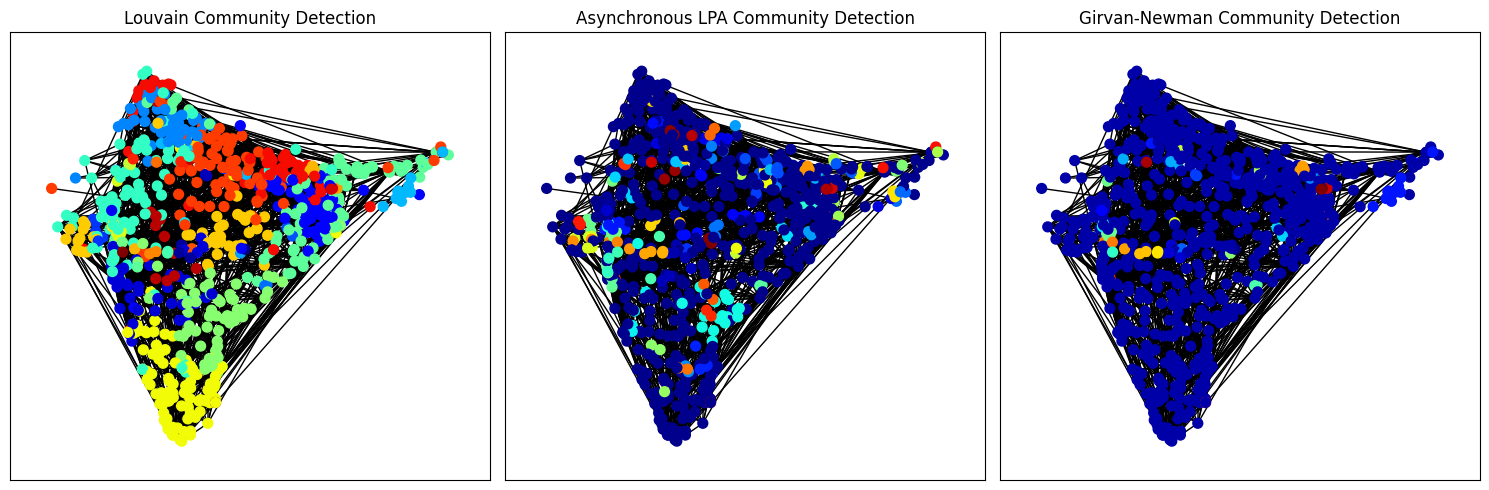

In [150]:
import matplotlib.pyplot as plt
import networkx as nx

# Assuming G is your networkx graph
# Assuming pos is the layout for your graph

# Detect communities using Louvain algorithm
communities_louvain = nx.community.louvain_communities(G)
# Create a mapping from node to community index
community_map_louvain = {node: idx for idx, community in enumerate(communities_louvain) for node in community}

# Detect communities using Asynchronous Label Propagation Algorithm (LPA)
communities_lpa = nx.algorithms.community.asyn_lpa_communities(G)
# Create a mapping from node to community index
community_map_lpa = {node: idx for idx, community in enumerate(communities_lpa) for node in community}

# Detect communities using Girvan-Newman algorithm
comp_gn = nx.algorithms.community.girvan_newman(G)
# Get the communities at the desired level of the dendrogram
communities_gn = tuple(sorted(c) for c in next(comp_gn))
# Create a mapping from node to community index
community_map_gn = {node: idx for idx, community in enumerate(communities_gn) for node in community}

# Color mapping
colors_louvain = [community_map_louvain[node] for node in G.nodes()]
colors_lpa = [community_map_lpa[node] for node in G.nodes()]
colors_gn = [community_map_gn[node] for node in G.nodes()]

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Louvain plot
axs[0].set_title('Louvain Community Detection')
nx.draw_networkx(G, pos=pos, node_color=colors_louvain, cmap=plt.cm.jet, node_size=50, with_labels=False, ax=axs[0])

# Asynchronous LPA plot
axs[1].set_title('Asynchronous LPA Community Detection')
nx.draw_networkx(G, pos=pos, node_color=colors_lpa, cmap=plt.cm.jet, node_size=50, with_labels=False, ax=axs[1])

# Girvan-Newman plot
axs[2].set_title('Girvan-Newman Community Detection')
nx.draw_networkx(G, pos=pos, node_color=colors_gn, cmap=plt.cm.jet, node_size=50, with_labels=False, ax=axs[2])

plt.tight_layout()
plt.show()


## Network under targetted and random removal

We next look at how the network behaves under targetted and random removal. For targetted removal, I removed the 10 nodes with the highest degrees, and for random removal, I removed 10 nodes randomly. Afterwhich I have a look at the degree distributions.

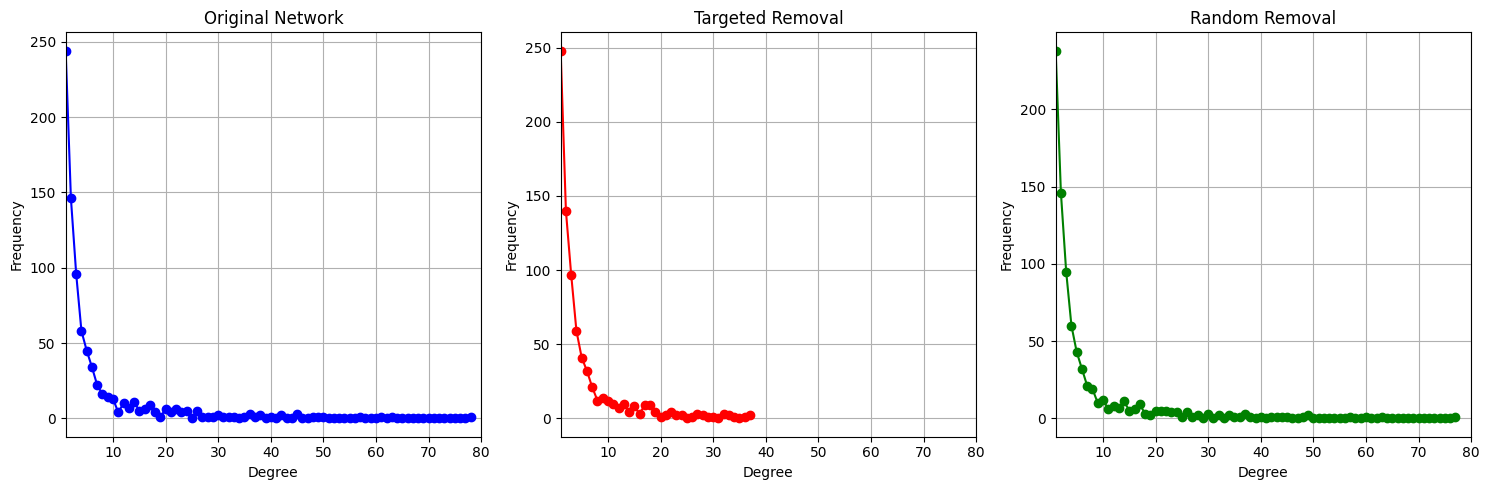

In [151]:
# Calculate the degree distribution of the original network
degree_sequence_original = sorted([d for n, d in G.degree()], reverse=True)
degree_counts_original = np.bincount(degree_sequence_original)

# Remove 10 nodes with the highest degrees
nodes_to_remove_targeted = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:10]
G_targeted_removal = G.copy()
G_targeted_removal.remove_nodes_from([n for n, _ in nodes_to_remove_targeted])
degree_sequence_targeted = sorted([d for n, d in G_targeted_removal.degree()], reverse=True)
degree_counts_targeted = np.bincount(degree_sequence_targeted)

# Remove 10 random nodes
random_nodes = np.random.choice(G.nodes(), size=10, replace=False)
G_random_removal = G.copy()
G_random_removal.remove_nodes_from(random_nodes)
degree_sequence_random = sorted([d for n, d in G_random_removal.degree()], reverse=True)
degree_counts_random = np.bincount(degree_sequence_random)

# Plot the degree distributions
plt.figure(figsize=(15, 5))

# Original network subplot
plt.subplot(1, 3, 1)
plt.plot(degree_counts_original, color='blue', marker='o')
plt.title('Original Network')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.xlim([1,80])
plt.grid(True)

# Targeted removal subplot
plt.subplot(1, 3, 2)
plt.plot(degree_counts_targeted, color='red', marker='o')
plt.title('Targeted Removal')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.xlim([1,80])
plt.grid(True)

# Random removal subplot
plt.subplot(1, 3, 3)
plt.plot(degree_counts_random, color='green', marker='o')
plt.title('Random Removal')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.xlim([1,80])
plt.grid(True)

plt.tight_layout()
plt.show()


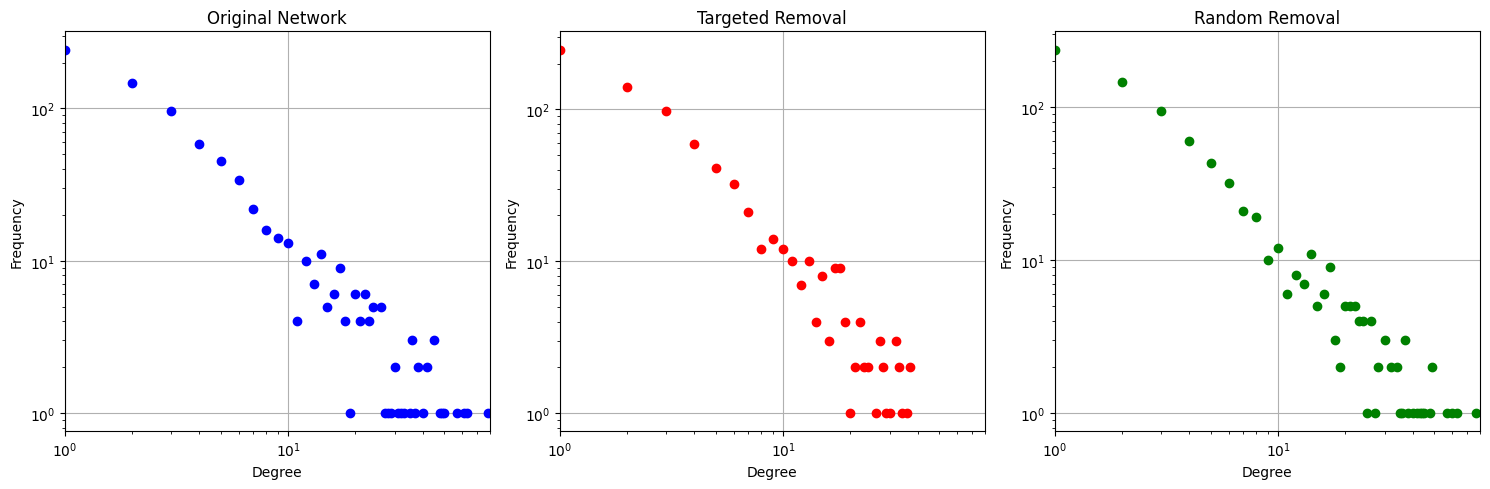

In [152]:
# Plot the degree distributions
plt.figure(figsize=(15, 5))

# Original network subplot
plt.subplot(1, 3, 1)
plt.loglog(degree_counts_original, color='blue', marker='o', linestyle='')
plt.title('Original Network')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.xlim([1,80])
plt.grid(True)

# Targeted removal subplot
plt.subplot(1, 3, 2)
plt.loglog(degree_counts_targeted, color='red', marker='o', linestyle='')
plt.title('Targeted Removal')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.xlim([1,80])
plt.grid(True)

# Random removal subplot
plt.subplot(1, 3, 3)
plt.loglog(degree_counts_random, color='green', marker='o', linestyle='')
plt.title('Random Removal')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.xlim([1,80])
plt.grid(True)

plt.tight_layout()
plt.show()


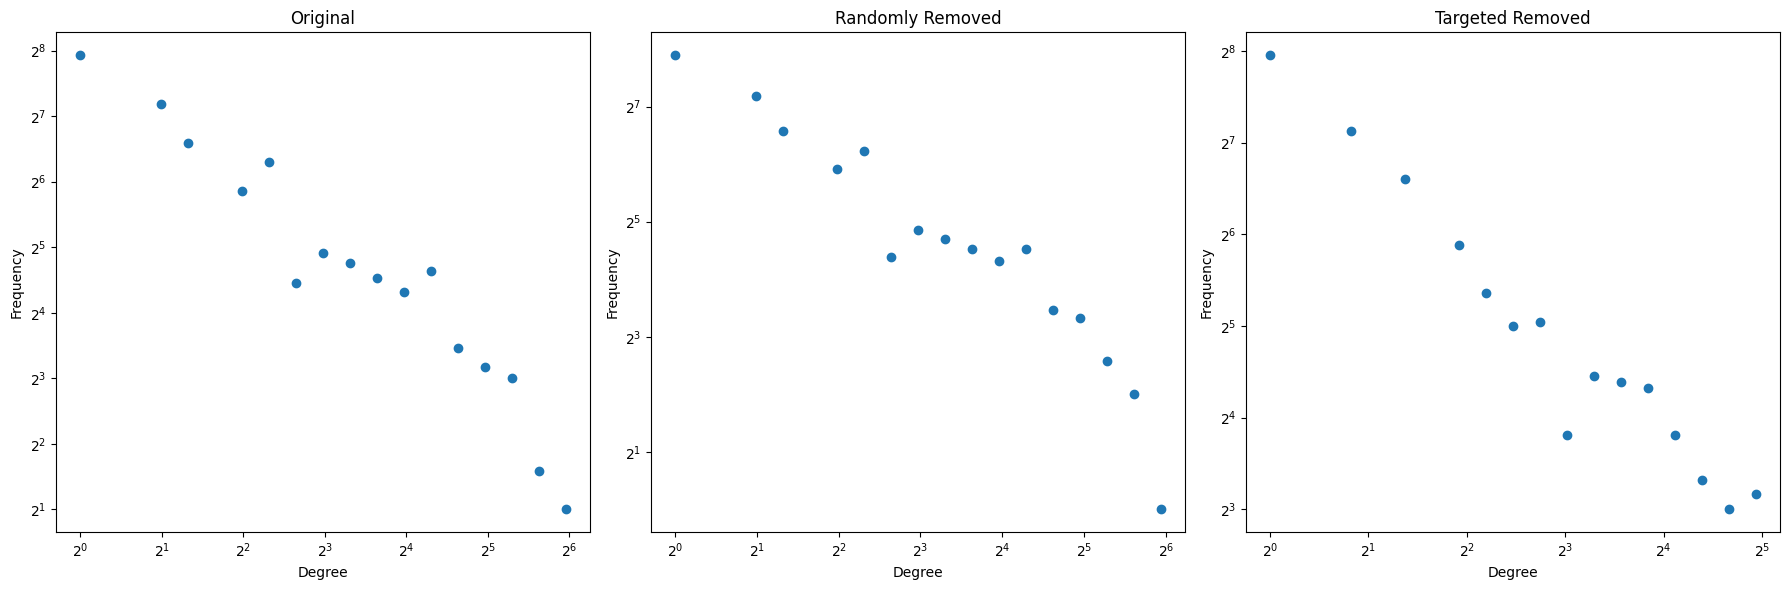

In [153]:
import collections

# Function to perform log binning
def log_binning(counter_dict, bin_count=10):
    max_exponent = np.log2(max(counter_dict.keys()))
    max_value = 2**max_exponent
    bins = np.logspace(0, max_exponent, num=bin_count, base=2)
    binned_counts = np.histogram(list(counter_dict.keys()), bins=bins, weights=list(counter_dict.values()))[0]
    binned_degrees = np.histogram(list(counter_dict.keys()), bins=bins)[1]
    return binned_degrees[:-1], binned_counts

# Create subplot axes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plotting for the original network
axes[0].set_title('Original')
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Frequency')
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degree_count = collections.Counter(degree_sequence)
binned_deg, binned_cnt = log_binning(degree_count, bin_count=20)
axes[0].loglog(binned_deg, binned_cnt, 'o', base=2)

# Plotting for randomly removed network
axes[1].set_title('Randomly Removed')
axes[1].set_xlabel('Degree')
axes[1].set_ylabel('Frequency')
degree_sequence_random = sorted([d for n, d in G_random_removal.degree()], reverse=True)
degree_count_random = collections.Counter(degree_sequence_random)
binned_deg_random, binned_cnt_random = log_binning(degree_count_random, bin_count=20)
axes[1].loglog(binned_deg_random, binned_cnt_random, 'o', base=2)

# Plotting for targeted removed network
axes[2].set_title('Targeted Removed')
axes[2].set_xlabel('Degree')
axes[2].set_ylabel('Frequency')
degree_sequence_targeted = sorted([d for n, d in G_targeted_removal.degree()], reverse=True)
degree_count_targeted = collections.Counter(degree_sequence_targeted)
binned_deg_targeted, binned_cnt_targeted = log_binning(degree_count_targeted, bin_count=20)
axes[2].loglog(binned_deg_targeted, binned_cnt_targeted, 'o', base=2)

plt.tight_layout()
plt.show()


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


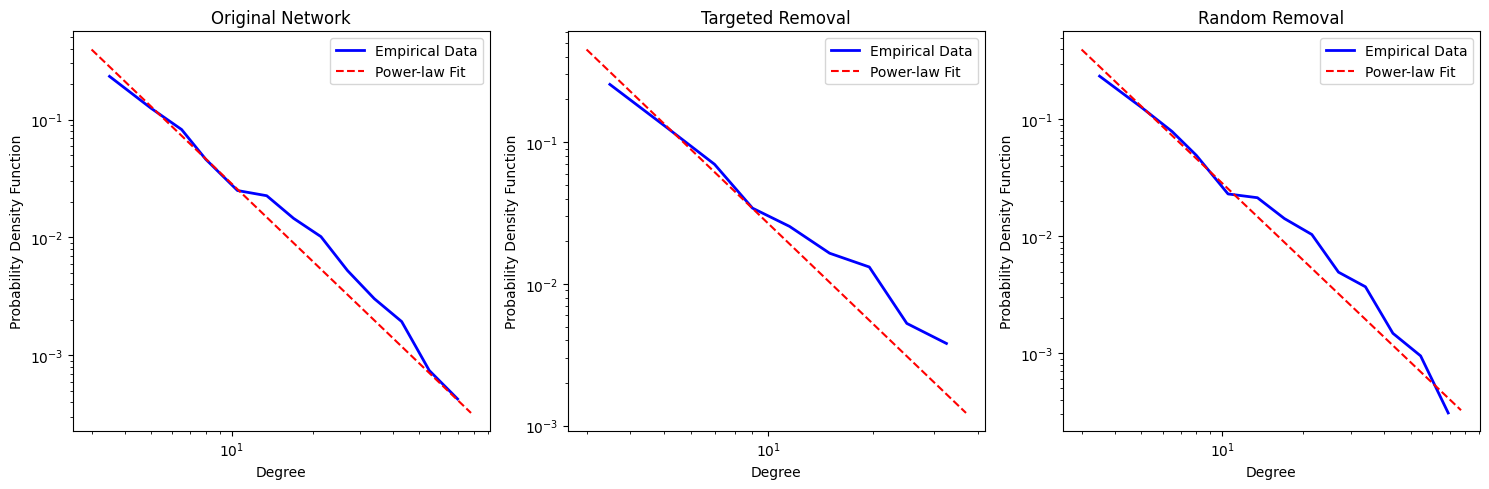

Original Network:
Estimated power-law exponent (alpha): 2.1780097001863705
Standard error of the exponent estimate (sigma): 0.057966067842710536

Targeted Removal:
Estimated power-law exponent (alpha): 2.349218002635858
Standard error of the exponent estimate (sigma): 0.06921342314739803

Random Removal:
Estimated power-law exponent (alpha): 2.189115422159542
Standard error of the exponent estimate (sigma): 0.05908762037871324


In [154]:
import powerlaw
import networkx as nx
import matplotlib.pyplot as plt

# Assuming G is your networkx graph
degrees_original = [degree for node, degree in G.degree() if degree > 0]  # Exclude nodes with degree 0

# Fit the degree distribution to a power-law distribution for the original network
fit_original = powerlaw.Fit(degree_sequence_original, xmin=3)
alpha_original = fit_original.power_law.alpha
sigma_original = fit_original.power_law.sigma

# Plot the degree distribution and the power-law fit for the original network
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot for the original network
fit_original.plot_pdf(color='b', linewidth=2, label='Empirical Data', ax=axes[0])
fit_original.power_law.plot_pdf(color='r', linestyle='--', label='Power-law Fit', ax=axes[0])
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Probability Density Function')
axes[0].set_title('Original Network')
axes[0].legend(loc='upper right')

# Fit the degree distribution to a power-law distribution for the network after targeted removal
# Assuming degrees_targeted is calculated earlier
fit_targeted = powerlaw.Fit(degree_sequence_targeted, xmin=3)
alpha_targeted = fit_targeted.power_law.alpha
sigma_targeted = fit_targeted.power_law.sigma

# Plot the degree distribution and the power-law fit for the network after targeted removal
fit_targeted.plot_pdf(color='b', linewidth=2, label='Empirical Data', ax=axes[1])
fit_targeted.power_law.plot_pdf(color='r', linestyle='--', label='Power-law Fit', ax=axes[1])
axes[1].set_xlabel('Degree')
axes[1].set_ylabel('Probability Density Function')
axes[1].set_title('Targeted Removal')
axes[1].legend(loc='upper right')

# Fit the degree distribution to a power-law distribution for the network after random removal
# Assuming degrees_random is calculated earlier
fit_random = powerlaw.Fit(degree_sequence_random, xmin=3)
alpha_random = fit_random.power_law.alpha
sigma_random = fit_random.power_law.sigma

# Plot the degree distribution and the power-law fit for the network after random removal
fit_random.plot_pdf(color='b', linewidth=2, label='Empirical Data', ax=axes[2])
fit_random.power_law.plot_pdf(color='r', linestyle='--', label='Power-law Fit', ax=axes[2])
axes[2].set_xlabel('Degree')
axes[2].set_ylabel('Probability Density Function')
axes[2].set_title('Random Removal')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

# Print the estimated power-law exponents and standard errors for all three cases
print("Original Network:")
print(f"Estimated power-law exponent (alpha): {alpha_original}")
print(f"Standard error of the exponent estimate (sigma): {sigma_original}")

print("\nTargeted Removal:")
print(f"Estimated power-law exponent (alpha): {alpha_targeted}")
print(f"Standard error of the exponent estimate (sigma): {sigma_targeted}")

print("\nRandom Removal:")
print(f"Estimated power-law exponent (alpha): {alpha_random}")
print(f"Standard error of the exponent estimate (sigma): {sigma_random}")


In [155]:
# Calculate the goodness of fit
R, p = fit_original.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print(f"Loglikelihood ratio (R) comparing power law and exponential distributions: {R}")
print(f"p-value of the likelihood ratio test: {p}")

# Interpretation of results
if p < 0.05:
    print("The power-law distribution is a significantly better fit than the exponential distribution.")
else:
    print("There is not enough evidence to conclude that the power-law distribution is a better fit than the exponential distribution.")

# Calculate the goodness of fit
R, p = fit_targeted.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print(f"Loglikelihood ratio (R) comparing power law and exponential distributions: {R}")
print(f"p-value of the likelihood ratio test: {p}")

# Interpretation of results
if p < 0.05:
    print("The power-law distribution is a significantly better fit than the exponential distribution.")
else:
    print("There is not enough evidence to conclude that the power-law distribution is a better fit than the exponential distribution.")

# Calculate the goodness of fit
R, p = fit_random.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print(f"Loglikelihood ratio (R) comparing power law and exponential distributions: {R}")
print(f"p-value of the likelihood ratio test: {p}")

# Interpretation of results
if p < 0.05:
    print("The power-law distribution is a significantly better fit than the exponential distribution.")
else:
    print("There is not enough evidence to conclude that the power-law distribution is a better fit than the exponential distribution.")


Loglikelihood ratio (R) comparing power law and exponential distributions: 4.746447543342176
p-value of the likelihood ratio test: 2.070203817894875e-06
The power-law distribution is a significantly better fit than the exponential distribution.
Loglikelihood ratio (R) comparing power law and exponential distributions: 3.7894520013358575
p-value of the likelihood ratio test: 0.00015097997949398972
The power-law distribution is a significantly better fit than the exponential distribution.
Loglikelihood ratio (R) comparing power law and exponential distributions: 4.873782894837903
p-value of the likelihood ratio test: 1.0948130350268321e-06
The power-law distribution is a significantly better fit than the exponential distribution.


## Global Effeciency

After targetted and random removal, I had a look at how the global effeciency of the network changes

In [156]:
efficiency_original = nx.global_efficiency(G)

# Remove 10 nodes with the highest degrees
nodes_to_remove_targeted = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:10]
G_targeted_removal = G.copy()
G_targeted_removal.remove_nodes_from([n for n, _ in nodes_to_remove_targeted])
efficiency_targeted = nx.global_efficiency(G_targeted_removal)

# Remove 10 random nodes
random_nodes = np.random.choice(G.nodes(), size=10, replace=False)
G_random_removal = G.copy()
G_random_removal.remove_nodes_from(random_nodes)
efficiency_random = nx.global_efficiency(G_random_removal)

print("Global Efficiency - Original Network:", efficiency_original)
print("Global Efficiency - After Targeted Removal:", efficiency_targeted)
print("Global Efficiency - After Random Removal:", efficiency_random)


Global Efficiency - Original Network: 0.2505304405376179
Global Efficiency - After Targeted Removal: 0.21025709309768287
Global Efficiency - After Random Removal: 0.24726625252569565
